# Homework 7: Gene expression, by experiment

#### **Please read the following instructions carefully before you continue.**

This template notebook is for Homework 7, due Thursday, May 30th, 2024.

To use this template, click `File` > `Save a copy in Drive`. You now have your own editable copy to which you can add your code. However, before you make changes, note that we've scaffolded this notebook to help get you started:

- We've already written `import` statements for all the modules you should need. This week, you could feasibly do everything without importing any external modules; do whatever is most helpful for you.
- We provide an introduction that lays out one potential approach for solving the problem, explaining what each logical "chunk" of your code ought to accomplish. You can use this as a starting point for writing your own code.  

Of course, if you'd rather do your own thing, you are not required to follow the path we've laid out, or use the modules we've recommended. However, a few things _are_ required (refer to the [Intro to Colab](https://colab.research.google.com/drive/1fq_HaiuYb1L18uGcoA3eGs6taiUafR-6?usp=sharing) notebook):

- _Literate style._ Dumping everything into a single, monstrous code cell is illegible and unacceptable. Remember to divide your code into reasonable, logical chunks, and to follow up each code cell with a text cell that explains and interprets the results. Try to minimize copy-and-pasting; instead, define functions and use thoughtful iteration to accomplish repetitive tasks.
- _Comments._ That said, writing "literate" code is not an excuse to avoid writing comments :)
- _Problem labels/numbers._ Please use text cells to clearly label where your solution to one problem ends, and the next begins.

Remember that a human is going to read and grade your notebook, so it is in your best interest to help them understand your work clearly. Your finished solution to a given problem should flow coherently from one code cell to the next. (Our "scaffold" helps you do this!)

If you get stuck, remember that [tutorials](https://bi1.caltech.edu/2023/tutorials) are held in-person each week.

---

## Introduction

This special "computational project" set serves as the culmination of all your hard work programming this quarter! You'll draw from many of the image segmentation skills you learned in HW 1, and combine them with the plotting you learned to do for HW 3 and 4. Finally, you'll compare your results with the theoretical predictions you made in HW 6.

Most excitingly, you'll use it all to study a real-world dataset, and recapitulate the analysis done in a real-world paper published just a few years ago. In other words, you are going to get your best taste yet of _real_ biological research.

This time, most of the information to get you started isn't included in this template file; instead, it's in the problem set text itself, as well as in the tutorial recordings and notebooks. Reach out if you have any questions!

In [1]:
## relevant imports
# the usual suspects
import numpy as np
import matplotlib.pyplot as plt

# working with filenames
import glob

# image processing
import skimage.io
import skimage.exposure
import skimage.measure

# csv work
import pandas as pd

# least-squares regression
import scipy.optimize

import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Answer to question 1a:**
abbreviate fold-change as fc
$$fc = 1/(1+(R/N_{NS})e^{- \Delta \varepsilon_{r}/ k_{B}T})$$
$$(R/N_{NS})e^{- \Delta \varepsilon_{r}/ k_{B}T} = 1/fc - 1$$
$$e^{- \Delta \varepsilon_{r}/ k_{B}T} = (N_{NS}/R)(1/fc - 1)$$
$${- \Delta \varepsilon_{r}/ k_{B}T} = ln((N_{NS}/R)(1/fc - 1))$$
$${\Delta \varepsilon_{r}} = -k_{B}T*ln((N_{NS}/R)(1/fc - 1))$$

for graphing 1b in terms of the units of $$k_{B}T$$:
we use the equation $${\Delta \varepsilon_{r}} = -ln((N_{NS}/R)(1/fc - 1))$$


## Question 1b

In [2]:
"""
Define a function to calculate delta epsilon R based on R
and the fold change.
"""
def epsilon_r(R, FC):
  return -np.log(((4.6*10**6)/R)*(1/FC - 1))

In [3]:
"""
Define a function to calculate fold change based on
R and epsilon.
"""
def fc(R, e):
  return 1/(1 + (R/(4.6*10**6))*np.exp(-e))

In [4]:
"""
Calculate the 3 different values for epsilon, with the
3 different fold changes given, and print this output.
"""
R = 260
FC = [2.77*10**(-3), 1.24*10**(-2), 0.477]
epsilon = []
for i in FC:
  epsilon.append(epsilon_r(R, i))

print(epsilon)

[-15.667019345677291, -14.158466515303829, -9.872950203620377]


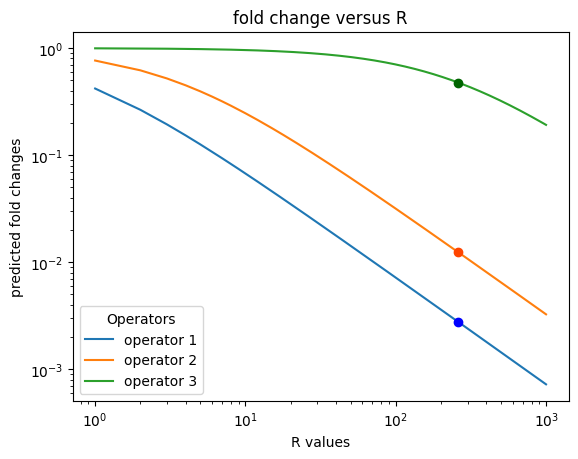

In [5]:
"""
Create lists for R, which ranges from 1 to 1000, a list for
the different values of epsilon to graph the given data at
the end, and empty lists whre the predicted fold changes will
be stored.
"""
R = list(range(1,10**3))
fc1 = []
fc2 = []
fc3 = []
eps = [-15.667019345677291, -14.158466515303829, -9.872950203620377]
#call the eps function defined above to calculate the fold change
for i in R:
  fc1.append(fc(i, eps[0]))
  fc2.append(fc(i, eps[1]))
  fc3.append(fc(i, eps[2]))

plt.plot(R, fc1, label = "operator 1")
plt.plot(R, fc2, label = "operator 2")
plt.plot(R, fc3, label = "operator 3")
plt.legend(title = "Operators")
plt.xlabel("R values")
plt.ylabel("predicted fold changes")
plt.title("fold change versus R")
plt.xscale('log')
plt.yscale('log')

plt.plot(260, FC[0], marker="o", color='blue')
plt.plot(260, FC[1], marker="o", color='orangered')
plt.plot(260, FC[2], marker="o", color='darkgreen')


## Question 1c



In [6]:
"""
Define a helper function to return an image given the image
file name, by joining it with the image directory and reading
the image.
"""
def get_img(img_path):
  image_directory = '/content/drive/MyDrive/lacI_titration/'
  img = os.path.join(image_directory, img_path)
  image = skimage.io.imread(img)
  return image


In [7]:
"""
Define a function as described in 1c in the homework set
that creates a segmentation mask for an image.
"""
def segment_im(im_phase, ip_dist=0.160, area_bounds=(1, 4), phase_thresh=0.3, show_mask=False):

    norm = (im_phase - im_phase.min()) / (im_phase.max() - im_phase.min())

    im_thresh = norm < phase_thresh
    im_lab, num_obj = skimage.measure.label(im_thresh, return_num=True)

    cells = np.zeros_like(im_thresh, dtype=bool)

    for i in range(1, num_obj + 1):
        cell = (im_lab == i)
        pixel_area = np.sum(cell)
        area = pixel_area * ip_dist**2
        if area_bounds[0] < area < area_bounds[1]:
            cells |= cell
    if show_mask:
        im_copy = np.stack([norm, norm, norm], axis=-1)
        im_copy[cells] = [1.0, 0.0, 1.0]
        plt.imshow(im_copy)
        plt.show()
    return cells



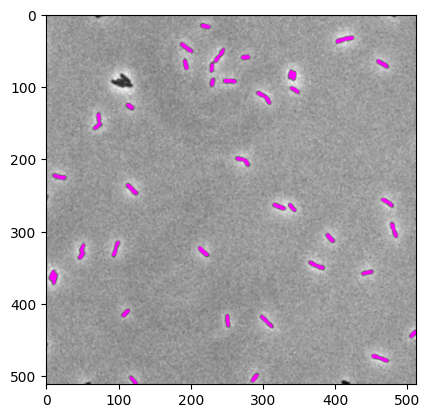

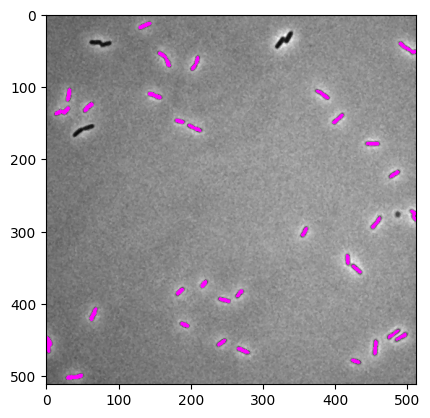

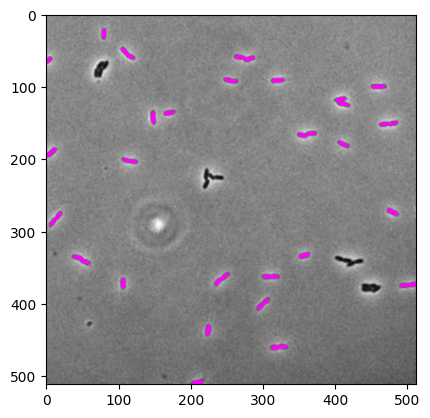

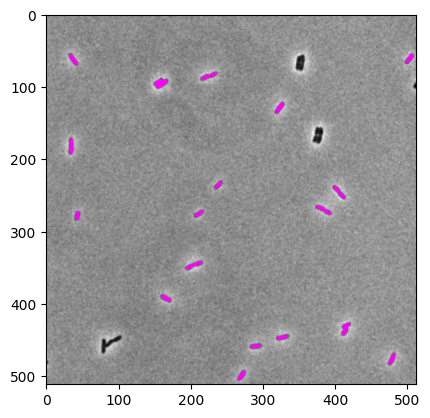

In [8]:
"""
Iterate through all the images described in question 1c, and
call the function written above to create a segmentation
mask and display this.
"""
images = ['O1_delta_phase_pos_01.tif', 'O2_delta_phase_pos_01.tif',
          'O3_auto_phase_pos_01.tif', 'O1_R60_phase_pos_01.tif']

for i in images:
    image = get_img(i)
    segmentation_mask = segment_im(image, ip_dist=0.160, area_bounds=(1, 4),
                      phase_thresh=0.3, show_mask=True)

## Question 1d

In [9]:
"""
Define a function that gets the intensities of all
of the segmentation cells, given the phase image
and the fluorescent image.
"""

def extract_intensities(im_phase, im_fluor):
    mask = segment_im(im_phase)
    im_lab, num = skimage.measure.label(mask, return_num=True)
    intensities = []
    for i in range(1, num + 1):
        cell = (im_lab == i)
        intensity = np.sum(cell * im_fluor)
        intensities.append(intensity)
    return intensities


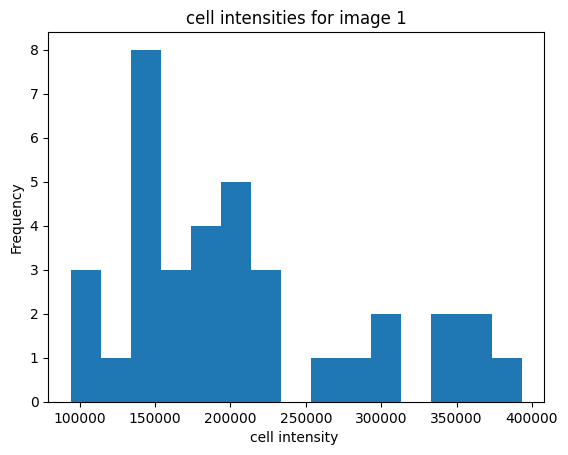

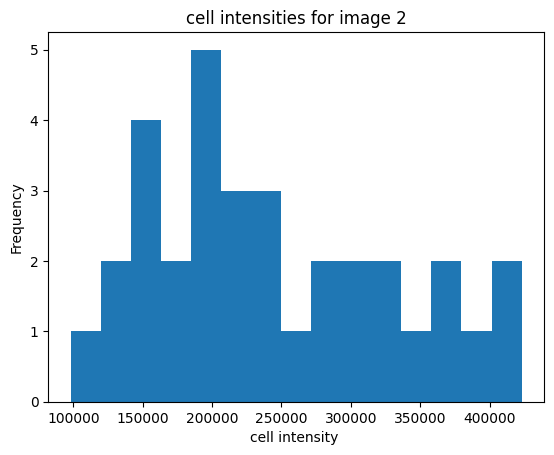

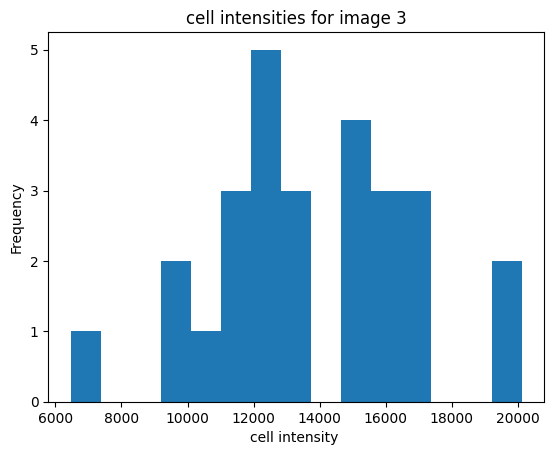

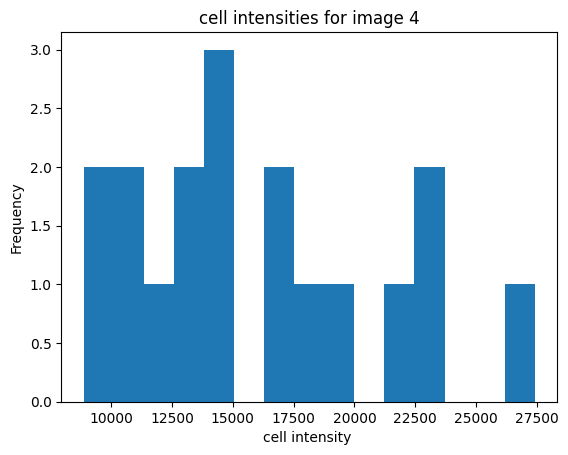

In [10]:
"""
Create lists with the file names for the phase images
and fluorescent images. Call the function written above
to get the intensities, and plot this in a histogram.
"""
phase_images = ['O1_delta_phase_pos_01.tif', 'O2_delta_phase_pos_01.tif',
                'O3_auto_phase_pos_01.tif', 'O1_R60_phase_pos_01.tif']
fluor_images = ['O1_delta_yfp_pos_01.tif', 'O2_delta_yfp_pos_01.tif',
                'O3_auto_yfp_pos_01.tif', 'O1_R60_yfp_pos_01.tif']
for i in range(len(phase_images)):
  phase = get_img(phase_images[i])
  fluor = get_img(fluor_images[i])
  intensity = extract_intensities(phase, fluor)
  plt.hist(intensity, bins = 15)
  plt.xlabel('cell intensity ')
  plt.ylabel('Frequency')
  plt.title('cell intensities for image ' +  str(i+1))
  plt.show()


## Question 1e

In [11]:
"""
Define a function as described in 1e that finds the images
of the desired repressor and operator labels and uses the
previously defined function to get the intensities.
"""
def strain_totals(op, rep):
  final = []
  image_directory = '/content/drive/MyDrive/lacI_titration/'
  phases = np.sort(glob.glob(image_directory + op + '_'
                                    + rep + '_phase*.tif'))
  fluors = np.sort(glob.glob(image_directory + op + '_'
                                    + rep + '_yfp*.tif'))

  for i in range(len(phases)):
    phase = get_img(phases[i])
    fluor = get_img(fluors[i])
    intensities = extract_intensities(phase, fluor)
    final.extend(intensities)
  return final


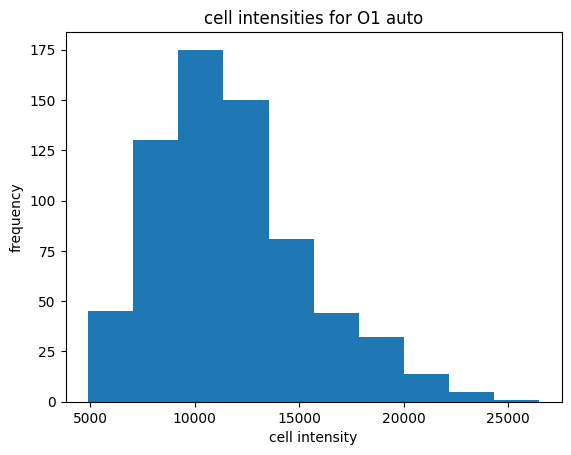

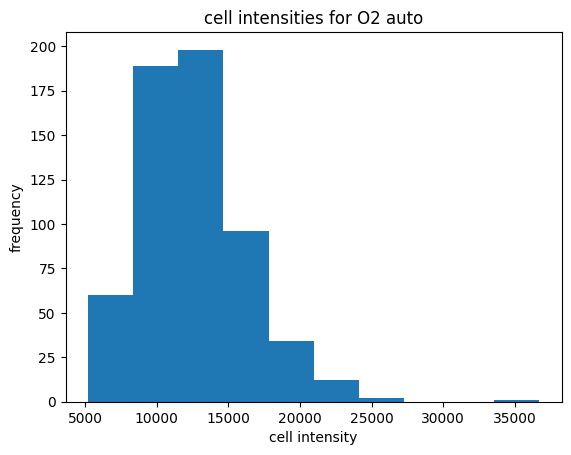

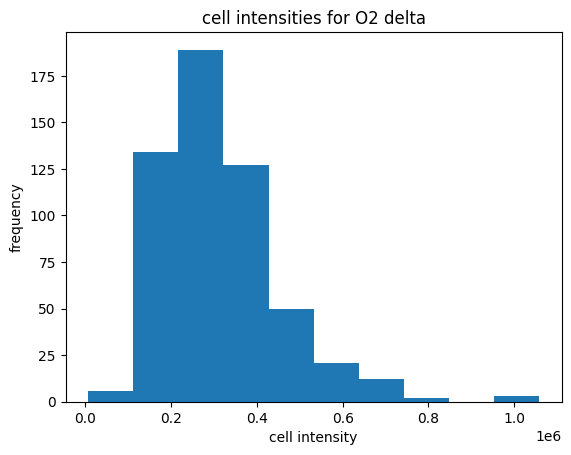

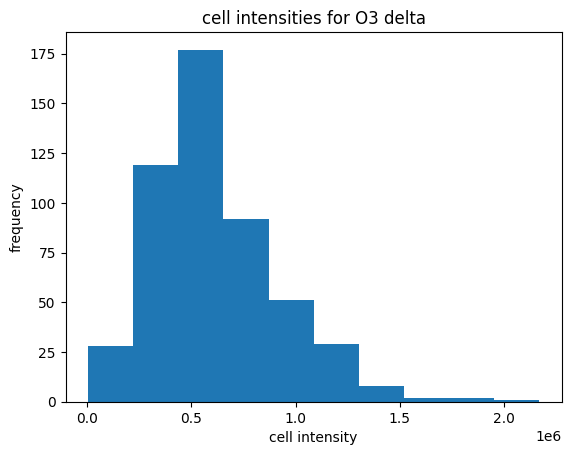

In [12]:
"""
Create lists for the desired operator and repressor
labels, and iterate through these lists and call
the function defined above to get the intensities
for all of them.
"""
ops = ['O1', 'O2', 'O2', 'O3']
reps = ['auto', 'auto', 'delta', 'delta']

for i in range(len(ops)):
  intensities = strain_totals(ops[i], reps[i])
  plt.hist(intensities)
  plt.title('cell intensities for ' + ops[i] + ' ' + reps[i])
  plt.xlabel('cell intensity')
  plt.ylabel('frequency')
  plt.show()

## Question 1f

In [13]:
"""
Iterate through the lists of operators and repressor
names to call the strain_totals function previously
defined and construct our matrix.
"""
ops = ['O1', 'O2', 'O3']
rep_names = ['R22', 'R60', 'R124', 'R260']

fc_vals = np.zeros((len(ops), len(rep_names)))
means = np.zeros((len(ops), len(rep_names)))

for i in range(len(ops)):
  auto = np.mean(strain_totals(ops[i], 'auto'))
  delta = np.mean(strain_totals(ops[i], 'delta'))

  for j in range(len(rep_names)):
    rep = np.mean(strain_totals(ops[i], rep_names[j]))
    means[i, j] = rep
    fc_vals[i, j] = (rep - auto)/(delta - auto)

print(fc_vals)


[[0.0210242  0.01909085 0.0097609  0.00557686]
 [0.14532349 0.04216874 0.0148685  0.00973137]
 [0.89913028 0.74661113 0.96938875 0.73675618]]


## Question 1g

[[ 15955.82466747  15569.48042705  13705.06649937  12868.96433878]
 [ 56388.49256198  25273.42857143  17038.72619048  15489.1884273 ]
 [551213.428051   459952.00137552 593253.31272727 454055.19047619]]


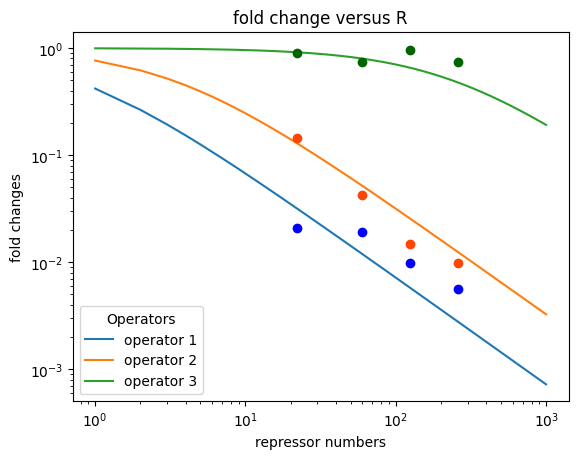

In [14]:
"""
Use the arrays constructed in the previous part to
plot the graphs and predicted values.
"""
rep_nums = [22, 60, 124, 260]

plt.plot(R, fc1, label = "operator 1")
plt.plot(R, fc2, label = "operator 2")
plt.plot(R, fc3, label = "operator 3")
plt.legend(title = "Operators")
plt.xlabel("repressor numbers")
plt.ylabel("fold changes")
plt.title("fold change versus R")
plt.xscale('log')
plt.yscale('log')

colors = ['blue', 'orangered', 'darkgreen']

print(means)

for i in range(len(ops)):
  for j in range(len(rep_nums)):
    plt.plot(rep_nums[j], fc_vals[i][j], marker="o", color = colors[i])

A possible reasons for the outliers shown on the graph could be because of the fluorescence of cells varies a lot. The outliers in fluorescence can biologically result from many reasons, such as cells clumping together, as the measured fluorescence would be the sum of multiple cell's fluorescence.

## Question 1h

In [15]:
"""
Define a function to calculate the log of
fold change based on R and epsilon.
"""
def fc_log(R, e):
  return np.log(1/(1 + (R/(4.6*10**6))*np.exp(-e)))

In [16]:
"""
Read in the lacZ data from the file and iterate
through the operators to get a list of delta
epsilon values from the least squares fitting of
the log of the lacZ data.
"""
lacZ = pd.read_csv('/content/drive/MyDrive/lacZ_titration_data.csv', header=8)
ops = ['O1', 'O2', 'O3']

lac_eps = []

for i in ops:
  r = lacZ[lacZ['operator'] == i]['repressor']
  fc_vals_lacZ = np.log(lacZ[lacZ['operator'] == i]['fold_change'])
  popt, pcov = scipy.optimize.curve_fit(fc_log, r, fc_vals_lacZ)
  lac_eps.append(popt[0])

print(lac_eps)
print(epsilon)

[-15.776722043610896, -14.170113368518724, -10.046001265092682]
[-15.667019345677291, -14.158466515303829, -9.872950203620377]


These delta epsilon values calculated from the least squares fitting are slightly smaller than fitting from only one data point.

## Question 1i

In [17]:
"""
Iterate through the operators to reverse the process previously
used to do a least squares regression, resulting in the
predicted binding energies.
"""
binding_E=[]
for i in range(len(ops)):
  popt, pcov = scipy.optimize.curve_fit(fc_log, rep_nums, np.log(fc_vals[i]))
  binding_E.append((popt[0]))

print(binding_E)
print(lac_eps)

[-15.334747885294352, -14.395320177051703, -8.75261549324254]
[-15.776722043610896, -14.170113368518724, -10.046001265092682]


These predicted binding energies found from the reversed process are slightly larger for operators 1 and 3, but slightly smaller for operator 2. This may be because fitting the whole function represents the data more wholistically than using just one point.

## Question 1j

Text(0.5, 1.0, 'fold change versus R')

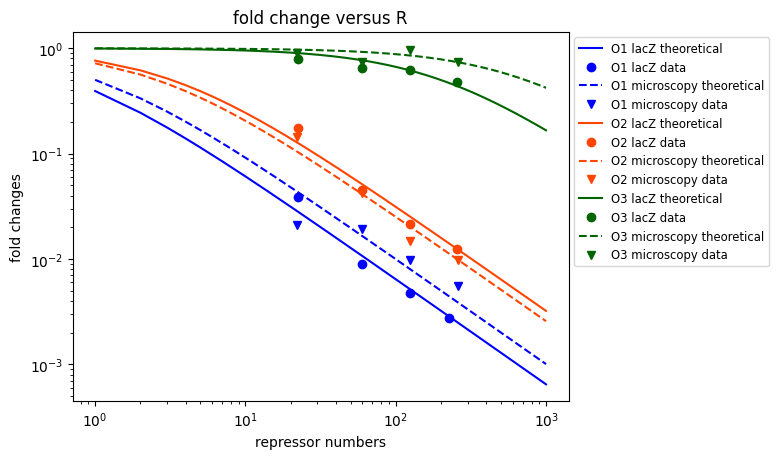

In [18]:
"""
Plot all of the data analyzed throughout the question by
iterating through the list of operators and appropriately
labeling the data of each plot.
"""
R = np.array(list(range(1,10**3)))

for i in range(len(ops)):
  plt.plot(R, fc(R,lac_eps[i]), color = colors[i], label = ops[i] + " lacZ theoretical")

  r = lacZ[lacZ['operator'] == ops[i]]['repressor']
  fc_vals_lacZ = (lacZ[lacZ['operator'] == ops[i]]['fold_change'])
  plt.plot(r,fc_vals_lacZ, 'o', color = colors[i], label = ops[i] + " lacZ data")

  plt.plot(R, fc(R,binding_E[i]), linestyle='--', color=colors[i], label = ops[i] + " microscopy theoretical")
  plt.plot(rep_nums, fc_vals[i,:], 'v',color = colors[i], label = ops[i] + " microscopy data")

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("repressor numbers")
plt.ylabel("fold changes")
plt.title("fold change versus R")



Based on these plots, the microscopy and lacZ methods both result in pretty similar experimental data. The theoretical data for these methods, however, are slightly spaced apart. The theoretical data may be different because precision when doing the least squares regression, as this is not always completely accurate.

---

### Submission instructions

When you're finished, recall the steps for submitting Colab notebooks:

1. Run all the cells from top-to-bottom, in order (`Runtime` > `Run all`).
2. Once the entire notebook has completed running and the output of all cells is visible, save it (`File` > `Save`).
3. Download the notebook in `.ipynb` format (`File` > `Download` > `Download .ipynb`).
4. Rename the file according to the usual convention (`lastname_firstname_hw#.ipynb`), if you haven't already.
5. Upload the file to Canvas.
